In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import cross_val_score

# 資料過採樣

In [18]:
# 讀取資料
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

X_test = test_data.drop(columns=['data_ID'])

# 分離特徵和目標變量
X_train= train_data.drop(columns=['data_ID', 'player_ID', 'level', 'play years', 'gender', 'hold racket handed'])  
y_train_level = train_data['level']
y_train_years = train_data['play years']
y_train_gender = train_data['gender']
y_train_hold = train_data['hold racket handed']

# 使用 SMOTE 增加少數類別的樣本
smote = SMOTE(random_state=42)

# 進行 SMOTE 過採樣
X_train_smote_level, y_train_smote_level = smote.fit_resample(X_train, y_train_level)
X_train_smote_years, y_train_smote_years = smote.fit_resample(X_train, y_train_years)
X_train_smote_gender, y_train_smote_gender = smote.fit_resample(X_train, y_train_gender)
X_train_smote_hold, y_train_smote_hold = smote.fit_resample(X_train, y_train_hold)

# 查看過採樣後的類別分佈
print("Original years dataset shape:", Counter(y_train_years))
print("Resampled years dataset shape:", Counter(y_train_smote_years))

print("Original level dataset shape:", Counter(y_train_level))
print("Resampled level dataset shape:", Counter(y_train_smote_level))

print("Original gender dataset shape:", Counter(y_train_gender))
print("Resampled gender dataset shape:", Counter(y_train_smote_gender))

print("Original hold dataset shape:", Counter(y_train_hold))
print("Resampled hold dataset shape:", Counter(y_train_smote_hold))

# 定義標準化函數
def standardize_data(X_train_smote, X_test):
    X_combined = pd.concat([X_train_smote, X_test], axis=0)
    scaler = StandardScaler()
    X_combined_scaled = scaler.fit_transform(X_combined)
    X_train_scaled = X_combined_scaled[:len(X_train_smote)]
    X_test_scaled = X_combined_scaled[len(X_train_smote):]
    return X_train_scaled, X_test_scaled

# 使用標準化函數
X_scaled_years, X_test_scaled_years = standardize_data(X_train_smote_years, X_test)
X_scaled_level, X_test_scaled_level = standardize_data(X_train_smote_level, X_test)
X_scaled_gender, X_test_scaled_gender = standardize_data(X_train_smote_gender, X_test)
X_scaled_hold, X_test_scaled_hold = standardize_data(X_train_smote_hold, X_test)

Original years dataset shape: Counter({0: 14430, 1: 9074, 2: 3016})
Resampled years dataset shape: Counter({0: 14430, 2: 14430, 1: 14430})
Original level dataset shape: Counter({0: 13702, 2: 10634, 1: 2184})
Resampled level dataset shape: Counter({2: 13702, 0: 13702, 1: 13702})
Original gender dataset shape: Counter({0: 20722, 1: 5798})
Resampled gender dataset shape: Counter({0: 20722, 1: 20722})
Original hold dataset shape: Counter({0: 23894, 1: 2626})
Resampled hold dataset shape: Counter({0: 23894, 1: 23894})


In [8]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

X_train= train_data.drop(columns=['data_ID', 'player_ID', 'gender', 'play years', 'hold racket handed', 'level'])
X_test = test_data.drop(columns=['data_ID'])

y_play_years = train_data['play years']
y_level = train_data['level']
y_gender = train_data['gender']
y_hold= train_data['hold racket handed']

# 合併資料進行正規化
X_combined = pd.concat([X_train, X_test], axis=0)
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

# 將正規化後的數據拆分回訓練集和測試集
X_scaled = X_combined_scaled[:len(X_train)]
X_test_scaled = X_combined_scaled[len(X_train):]

In [3]:
from xgboost import XGBClassifier, XGBRegressor
import pandas as pd

# 假設 X_scaled_years, X_scaled_level, X_scaled_gender, X_scaled_hold 是正規化後的訓練集特徵
# y_train_smote_years, y_train_smote_level, y_train_smote_gender, y_train_smote_hold 是四個目標變量的訓練標籤

# 定義特徵篩選函數
def feature_selection(model, X_train, y_train, threshold):
    model.fit(X_train, y_train)
    feature_importances = model.feature_importances_
    selected_features = X_train.columns[feature_importances > threshold]
    return selected_features

# 特徵篩選 - years
years_model = XGBClassifier(objective='multi:softmax', num_class=3, n_jobs=-1)
selected_features_years = feature_selection(years_model, pd.DataFrame(X_scaled_years, columns=X_train.columns), y_train_smote_years, 0.01)
X_train_selected_years = pd.DataFrame(X_scaled_years, columns=X_train.columns)[selected_features_years]
X_test_selected_years = pd.DataFrame(X_test_scaled_years, columns=X_train.columns)[selected_features_years]

# 特徵篩選 - level
level_model = XGBClassifier(objective='multi:softmax', num_class=3, n_jobs=-1)
selected_features_level = feature_selection(level_model, pd.DataFrame(X_scaled_level, columns=X_train.columns), y_train_smote_level, 0.01)
X_train_selected_level = pd.DataFrame(X_scaled_level, columns=X_train.columns)[selected_features_level]
X_test_selected_level = pd.DataFrame(X_test_scaled_level, columns=X_train.columns)[selected_features_level]

# 特徵篩選 - gender
gender_model = XGBClassifier(objective='multi:softmax', num_class = 2, n_jobs=-1)
selected_features_gender = feature_selection(gender_model, pd.DataFrame(X_scaled_gender, columns=X_train.columns), y_train_smote_gender, 0.03)
X_train_selected_gender = pd.DataFrame(X_scaled_gender, columns=X_train.columns)[selected_features_gender]
X_test_selected_gender = pd.DataFrame(X_test_scaled_gender, columns=X_train.columns)[selected_features_gender]

# 特徵篩選 - hold
hold_model = XGBClassifier(objective='multi:softmax', num_class = 2, n_jobs=-1)
selected_features_hold = feature_selection(hold_model, pd.DataFrame(X_scaled_hold, columns=X_train.columns), y_train_smote_hold, 0.05)
X_train_selected_hold = pd.DataFrame(X_scaled_hold, columns=X_train.columns)[selected_features_hold]
X_test_selected_hold = pd.DataFrame(X_test_scaled_hold, columns=X_train.columns)[selected_features_hold]

# 查看每個目標變量的選定特徵
print("Selected features for years:", selected_features_years)
print("Selected features for level:", selected_features_level)
print("Selected features for gender:", selected_features_gender)
print("Selected features for hold:", selected_features_hold)

NameError: name 'X_scaled_years' is not defined

In [9]:
from xgboost import XGBClassifier, XGBRegressor
import pandas as pd

# 假設 X_scaled_years, X_scaled_level, X_scaled_gender, X_scaled_hold 是正規化後的訓練集特徵
# y_train_smote_years, y_train_smote_level, y_train_smote_gender, y_train_smote_hold 是四個目標變量的訓練標籤

# 定義特徵篩選函數
def feature_selection(model, X_train, y_train, threshold):
    model.fit(X_train, y_train)
    feature_importances = model.feature_importances_
    selected_features = X_train.columns[feature_importances > threshold]
    return selected_features

# 特徵篩選 - years
years_model = XGBClassifier(
    objective='multi:softmax', num_class=3, n_jobs=-1, random_state = 42
)
selected_features_years = feature_selection(years_model, pd.DataFrame(X_scaled, columns=X_train.columns), y_play_years, 0.01)
X_train_selected_years = pd.DataFrame(X_scaled, columns=X_train.columns)[selected_features_years]
X_test_selected_years = pd.DataFrame(X_test_scaled, columns=X_train.columns)[selected_features_years]

# 特徵篩選 - level
level_model = XGBClassifier(
    objective='multi:softmax', num_class=3, n_jobs=-1, random_state = 42
)
selected_features_level = feature_selection(level_model, pd.DataFrame(X_scaled, columns=X_train.columns), y_level, 0.01)
X_train_selected_level = pd.DataFrame(X_scaled, columns=X_train.columns)[selected_features_level]
X_test_selected_level = pd.DataFrame(X_test_scaled, columns=X_train.columns)[selected_features_level]

# 特徵篩選 - gender
gender_model = XGBClassifier(
    objective='multi:softmax', num_class=2, n_jobs=-1, random_state = 42
)
selected_features_gender = feature_selection(gender_model, pd.DataFrame(X_scaled, columns=X_train.columns), y_gender, 0.01)
X_train_selected_gender = pd.DataFrame(X_scaled, columns=X_train.columns)[selected_features_gender]
X_test_selected_gender = pd.DataFrame(X_test_scaled, columns=X_train.columns)[selected_features_gender]

# 特徵篩選 - hold
hold_model = XGBClassifier(
    objective='multi:softmax', num_class=2, n_jobs=-1, random_state = 42
)
selected_features_hold = feature_selection(hold_model, pd.DataFrame(X_scaled, columns=X_train.columns), y_hold, 0.009)
X_train_selected_hold = pd.DataFrame(X_scaled, columns=X_train.columns)[selected_features_hold]
X_test_selected_hold = pd.DataFrame(X_test_scaled, columns=X_train.columns)[selected_features_hold]

# 查看每個目標變量的選定特徵
print("Selected features for years:", selected_features_years)
print("Selected features for level:", selected_features_level)
print("Selected features for gender:", selected_features_gender)
print("Selected features for hold:", selected_features_hold)

Selected features for years: Index(['ax_mean', 'ay_mean', 'az_mean', 'gx_mean', 'gy_mean', 'gz_mean',
       'ax_var', 'ay_var', 'az_var', 'gx_var', 'gy_var', 'gz_var', 'ax_rms',
       'ay_rms', 'az_rms', 'gx_rms', 'gy_rms', 'gz_rms', 'a_max', 'a_mean',
       'g_max', 'g_mean', 'a_kurt', 'g_kurt', 'a_skewn', 'g_skewn',
       'a_entropy'],
      dtype='object')
Selected features for level: Index(['ax_mean', 'ay_mean', 'az_mean', 'gx_mean', 'gy_mean', 'gz_mean',
       'ax_var', 'ay_var', 'az_var', 'gx_var', 'gy_var', 'gz_var', 'ax_rms',
       'ay_rms', 'az_rms', 'gx_rms', 'gy_rms', 'gz_rms', 'a_max', 'a_mean',
       'g_max', 'g_mean', 'a_kurt', 'a_skewn', 'g_skewn', 'a_entropy'],
      dtype='object')
Selected features for gender: Index(['ax_mean', 'ay_mean', 'az_mean', 'gx_mean', 'gy_mean', 'gz_mean',
       'ax_var', 'ay_var', 'az_var', 'gx_var', 'gy_var', 'gz_var', 'ax_rms',
       'ay_rms', 'az_rms', 'gx_rms', 'gy_rms', 'gz_rms', 'a_max', 'a_mean',
       'g_max', 'g_mean', 'a_

[0.03839009 0.02596192 0.07862056 0.07280279 0.04217091 0.02548609
 0.02233709 0.01411394 0.04031643 0.05017218 0.03717333 0.02411547
 0.03161973 0.01876858 0.02667592 0.02272012 0.03535844 0.0719078
 0.01652938 0.04915507 0.00841108 0.04528467 0.07404339 0.00617929
 0.00774607 0.         0.00654113 0.         0.01036175 0.02101193
 0.04119959 0.02371669 0.01110859 0.        ]


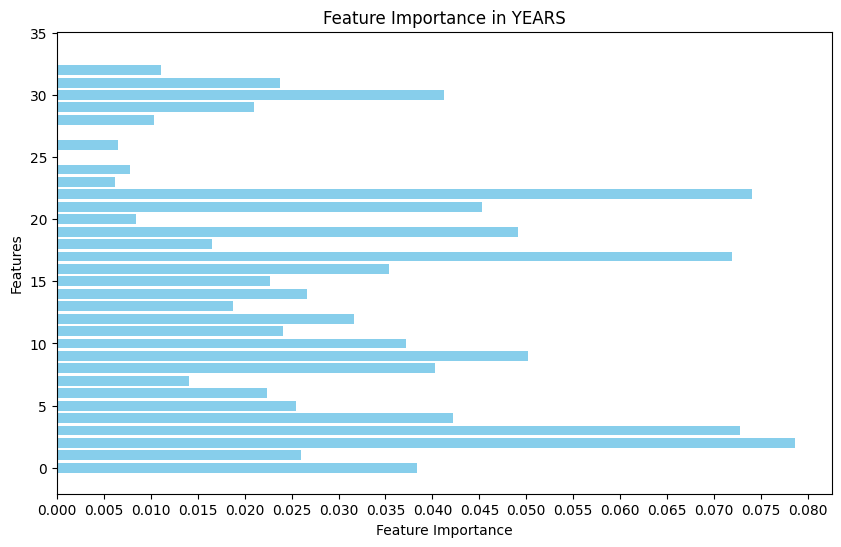

In [149]:
# YEARS Feature check  #有資料擴充
model = XGBClassifier()
model.fit(X_scaled, y_play_years)  #X_scaled_years, y_train_smote_years
feature_importances = model.feature_importances_
print(feature_importances)

features = X_scaled.columns if hasattr(X_scaled, 'columns') else np.arange(len(feature_importances))

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in YEARS")
plt.xticks(np.arange(0, max(feature_importances) + 0.005, 0.005))  # 刻度間隔為 0.01
plt.show()

[0.03038548 0.02372851 0.03919483 0.15994263 0.03671588 0.03342837
 0.01962991 0.01418039 0.01986757 0.05718179 0.04689867 0.0150648
 0.03927409 0.01917393 0.0373206  0.01311694 0.03405754 0.08412626
 0.01750157 0.01868319 0.00801301 0.04759144 0.05863667 0.00542922
 0.00675045 0.         0.00667545 0.         0.04305419 0.00986592
 0.02838316 0.01441052 0.01171698 0.        ]


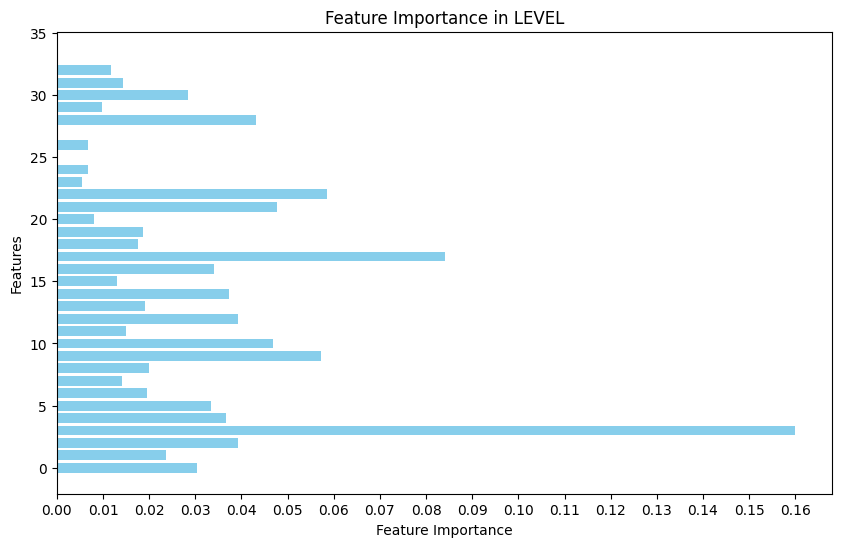

In [ ]:
# LEVEL Feature check
model = XGBClassifier()
model.fit(X_scaled, y_level) #X_scaled_level, y_train_smote_level
feature_importances = model.feature_importances_
print(feature_importances)

features = X_scaled.columns if hasattr(X_scaled, 'columns') else np.arange(len(feature_importances))

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in LEVEL")
plt.xticks(np.arange(0, max(feature_importances) + 0.01, 0.01))  # 刻度間隔為 0.01
plt.show()

[0.02216889 0.02680496 0.2479737  0.02547851 0.04026407 0.06723336
 0.04477816 0.01433424 0.06954367 0.0135995  0.07957545 0.01718527
 0.01404325 0.01334672 0.0405858  0.03531542 0.01604915 0.03224133
 0.01035602 0.01412144 0.01021083 0.01852593 0.04462113 0.00504231
 0.00737069 0.         0.00573884 0.         0.01092293 0.01031974
 0.01783517 0.01616653 0.00824698 0.        ]


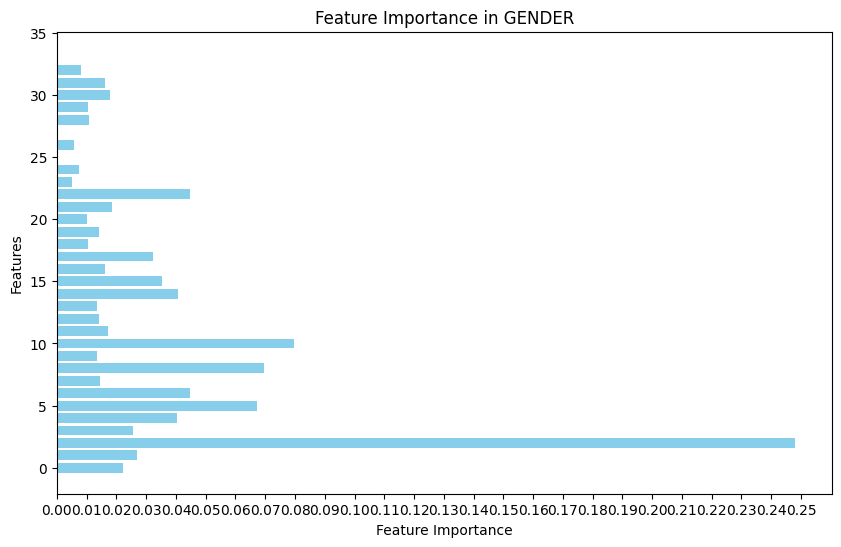

In [22]:
# GENDER Feature check
model = XGBClassifier()
model.fit(X_scaled, y_gender) #X_scaled_gender, y_train_smote_gender
feature_importances = model.feature_importances_
print(feature_importances)

features = X_scaled.columns if hasattr(X_scaled, 'columns') else np.arange(len(feature_importances))

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.xlabel("Feature Importance") 
plt.ylabel("Features")
plt.title("Feature Importance in GENDER")
plt.xticks(np.arange(0, max(feature_importances) + 0.01, 0.01))  # 刻度間隔為 0.01
plt.show()

In [23]:
print(sorted(feature_importances))

[np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.005042307), np.float32(0.0057388446), np.float32(0.007370689), np.float32(0.008246976), np.float32(0.010210828), np.float32(0.010319742), np.float32(0.01035602), np.float32(0.0109229265), np.float32(0.013346716), np.float32(0.0135995), np.float32(0.014043253), np.float32(0.014121438), np.float32(0.014334238), np.float32(0.016049154), np.float32(0.016166534), np.float32(0.017185275), np.float32(0.017835172), np.float32(0.018525934), np.float32(0.022168892), np.float32(0.02547851), np.float32(0.026804961), np.float32(0.03224133), np.float32(0.035315417), np.float32(0.04026407), np.float32(0.040585797), np.float32(0.04462113), np.float32(0.04477816), np.float32(0.06723336), np.float32(0.06954367), np.float32(0.07957545), np.float32(0.2479737)]


[0.01589015 0.00793137 0.01355052 0.01368617 0.5795639  0.00745706
 0.0029441  0.00343742 0.03334339 0.00923766 0.0502879  0.00417837
 0.01577997 0.00434425 0.01239127 0.00383699 0.02763657 0.00814536
 0.00904108 0.04166509 0.00162657 0.00826819 0.0859943  0.00183002
 0.0030467  0.         0.00346905 0.         0.00390308 0.01129876
 0.00517512 0.00687651 0.00416308 0.        ]


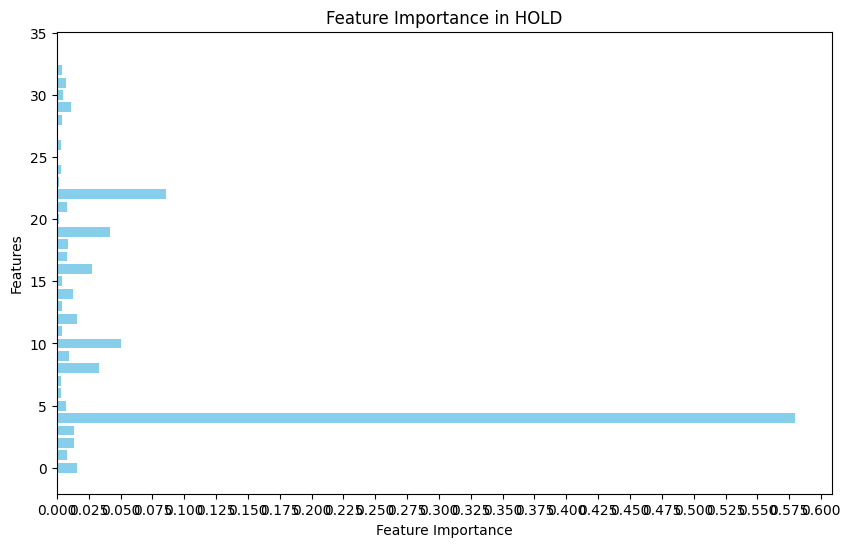

In [19]:
# HOLD Feature check 
model = XGBClassifier()
model.fit(X_scaled, y_hold) #X_scaled_hold, y_train_smote_hold
feature_importances = model.feature_importances_
print(feature_importances)

features = X_scaled.columns if hasattr(X_scaled, 'columns') else np.arange(len(feature_importances))

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in HOLD")
plt.xticks(np.arange(0, max(feature_importances) + 0.025, 0.025))  # 刻度間隔為 0.01
plt.show()

In [20]:
'''
X_scaled_years, X_test_scaled_years = standardize_data(X_train_smote_years, X_test)
X_scaled_level, X_test_scaled_level = standardize_data(X_train_smote_level, X_test)
X_scaled_gender, X_test_scaled_gender = standardize_data(X_train_smote_gender, X_test)
X_scaled_hold, X_test_scaled_hold = standardize_data(X_train_smote_hold, X_test)
'''

'\nX_scaled_years, X_test_scaled_years = standardize_data(X_train_smote_years, X_test)\nX_scaled_level, X_test_scaled_level = standardize_data(X_train_smote_level, X_test)\nX_scaled_gender, X_test_scaled_gender = standardize_data(X_train_smote_gender, X_test)\nX_scaled_hold, X_test_scaled_hold = standardize_data(X_train_smote_hold, X_test)\n'

In [10]:
play_years_model = XGBClassifier(
    objective='multi:softmax', 
    num_class=3,
    random_state = 42, 
    n_jobs = -1
)
play_years_model.fit(X_train_selected_years, y_play_years, verbose=100)

y_pred_years = play_years_model.predict_proba(X_test_selected_years)

level_model = XGBClassifier(
    objective='multi:softmax', 
    num_class=3,
    random_state = 42, 
    n_jobs=-1
) 
level_model.fit(X_train_selected_level, y_level, verbose=100)

y_pred_level = level_model.predict_proba(X_test_selected_level)

In [11]:
gender_model = XGBClassifier(
    objective='multi:softmax', 
    num_class=2,
    random_state = 42, 
    n_jobs = -1
) 
gender_model.fit(X_train_selected_gender, y_gender, verbose=True)

y_pred_gender = gender_model.predict_proba(X_test_selected_gender)

hold_model = XGBClassifier(
    objective='multi:softmax', 
    num_class=2,
    random_state = 42, 
    n_jobs=-1
)
hold_model.fit(X_train_selected_hold, y_hold, verbose=True)

y_pred_hold = hold_model.predict_proba(X_test_selected_hold)

In [18]:
cat_gender = pd.read_csv('./catboost_bayesian_logs/gender_submission.csv')
print(cat_gender['gender'].head(5))
cat_level = pd.read_csv('./catboost_bayesian_logs/level_submission.csv')
print(cat_level.head(5))
cat_play_years = pd.read_csv('./catboost_bayesian_logs/play_years_submission.csv')
print(cat_play_years.head(5))

0    0.290070
1    0.000266
2    0.000858
3    0.003694
4    0.015656
Name: gender, dtype: float64
    level_0   level_1   level_2
0  0.798867  0.003395  0.197738
1  0.005729  0.000667  0.993605
2  0.007909  0.000010  0.992081
3  0.013019  0.000016  0.986965
4  0.016404  0.000015  0.983581
   play years_0  play years_1  play years_2
0      0.055348      0.887812      0.056841
1      0.999700      0.000263      0.000038
2      0.997482      0.001163      0.001355
3      0.999013      0.000586      0.000401
4      0.996647      0.002248      0.001105


In [23]:
submission = pd.DataFrame({
    'data_ID': test_data['data_ID'],
    'gender': y_pred_gender[:, 1],
    'hold racket handed': y_pred_hold[:, 1],
    'play years_0': cat_play_years['play years_0'],
    'play years_1': cat_play_years['play years_1'],
    'play years_2': cat_play_years['play years_2'],
    'level_0': cat_level['level_0'],
    'level_1': cat_level['level_1'],
    'level_2': cat_level['level_2']
})

# 儲存提交檔案
submission.to_csv('submission.csv', index=False)

# 一般資料處理

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

X = train_data.drop(columns=['data_ID', 'player_ID', 'gender', 'play years', 'hold racket handed', 'level'])
X_test = test_data.drop(columns=['data_ID'])

y_play_years = train_data['play years']
y_level = train_data['level']
y_gender = train_data['gender']
y_hold= train_data['hold racket handed']

# 合併資料進行正規化
X_combined = pd.concat([X, X_test], axis=0)
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

# 將正規化後的數據拆分回訓練集和測試集
X_scaled = X_combined_scaled[:len(X)]
X_test_scaled = X_combined_scaled[len(X):]

X_train_play_years, X_val_play_years, y_train_play_years, y_val_play_years = train_test_split(X_scaled, y_play_years, test_size=0.1, random_state=42)
X_train_level, X_val_level, y_train_level, y_val_level = train_test_split(X_scaled, y_level, test_size=0.1, random_state=42)
X_train_gender, X_val_gender, y_train_gender, y_val_gender = train_test_split(X_scaled, y_gender, test_size=0.1, random_state=42)
X_train_hold, X_val_hold, y_train_hold, y_val_hold = train_test_split(X_scaled, y_hold, test_size=0.1, random_state=42)

# 設定 K-fold 參數
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# 使用布林遮罩進行特徵篩選的函數
def feature_selection(model, X_train, y_train, threshold=0.015):
    model.fit(X_train, y_train)
    feature_importances = model.feature_importances_
    selected_features = X.columns[feature_importances > threshold]
    return selected_features

play_years_model = XGBClassifier(objective='multi:softmax', num_class=3, n_jobs=-1)#objective='multi:softprob', num_class=3
selected_features_play_years = feature_selection(play_years_model, pd.DataFrame(X_scaled, columns=X.columns), y_play_years)

X_train_play_years = pd.DataFrame(X_scaled, columns=X.columns)[selected_features_play_years]
X_val_play_years = pd.DataFrame(X_val_play_years, columns=X.columns)[selected_features_play_years]
X_test_play_years = pd.DataFrame(X_test_scaled, columns=X.columns)[selected_features_play_years]

level_model = XGBClassifier(objective='multi:softmax', num_class=3, n_jobs=-1)#objective='multi:softprob', num_class=3
selected_features_level = feature_selection(level_model, pd.DataFrame(X_scaled, columns=X.columns), y_level)

X_train_level = pd.DataFrame(X_scaled, columns=X.columns)[selected_features_level]
X_val_level = pd.DataFrame(X_val_level, columns=X.columns)[selected_features_level]
X_test_level = pd.DataFrame(X_test_scaled, columns=X.columns)[selected_features_level]

gender_model = XGBClassifier(objective='multi:softmax', num_class=2, n_jobs=-1)#objective='binary:logistic'
selected_features_gender = feature_selection(gender_model, pd.DataFrame(X_scaled, columns=X.columns), y_gender)

X_train_gender = pd.DataFrame(X_scaled, columns=X.columns)[selected_features_gender]
X_val_gender = pd.DataFrame(X_val_gender, columns=X.columns)[selected_features_gender]
X_test_gender = pd.DataFrame(X_test_scaled, columns=X.columns)[selected_features_gender]


hold_model = XGBClassifier(objective='multi:softmax', num_class=2, n_jobs=-1)#objective='binary:logistic')
selected_features_hold = feature_selection(hold_model, pd.DataFrame(X_scaled, columns=X.columns), y_hold)

X_train_hold = pd.DataFrame(X_scaled, columns=X.columns)[selected_features_hold]
X_val_hold = pd.DataFrame(X_val_hold, columns=X.columns)[selected_features_hold]
X_test_hold = pd.DataFrame(X_test_scaled, columns=X.columns)[selected_features_hold]


In [ ]:
# 特徵篩選函數
def feature_selection(model, X_train, y_train, threshold):
    model.fit(X_train, y_train)
    feature_importances = model.feature_importances_
    selected_features = X_train.columns[feature_importances > threshold]
    return selected_features

# 定義模型和目標變量
models = {
    'play_years': (XGBClassifier(objective='multi:softmax', num_class=3, n_jobs=-1), y_play_years),
    'level': (XGBClassifier(objective='multi:softmax', num_class=3, n_jobs=-1), y_level),
    'gender': (XGBClassifier(objective='multi:softmax', num_class=2, n_jobs=-1), y_gender),
    'hold': (XGBClassifier(objective='multi:softmax', num_class=2, n_jobs=-1), y_hold)
}

# 設置閾值範圍
thresholds = [0.01, 0.015, 0.02, 0.025, 0.03]

# 儲存結果的字典
results = {name: [] for name in models.keys()}

# 對每個模型和閾值進行特徵篩選並計算分數
for name, (model, y_train) in models.items():
    for threshold in thresholds:
        selected_features = feature_selection(model, pd.DataFrame(X_scaled, columns=X.columns), y_train, threshold)
        
        # 根據選定的特徵重新構建數據集
        X_train_selected = pd.DataFrame(X_scaled, columns=X.columns)[selected_features]
        
        # 使用交叉驗證計算分數（例如 AUC 或準確率）
        score = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='accuracy').mean()
        results[name].append(score)

# 繪製每個模型的閾值 - 分數圖表
plt.figure(figsize=(12, 8))
for name in models.keys():
    plt.plot(thresholds, results[name], label=f'{name} Model')
plt.xlabel('Feature Importance Threshold')
plt.ylabel('Cross-Validated Score (Accuracy)')
plt.title('Threshold vs Model Performance')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [ ]:
param_dist = {
    'n_estimators': [420, 425, 430],
    'learning_rate': [0.13, 0.15, 0.17],
    'max_depth': [8, 9, 10],
    'subsample': [0.675, 0.7, 0.725],
    'colsample_bytree': [0.76, 0.775, 0.79]
}
other_params = {
    # ----通用參數----#
    #'booster': 'gbtree',
    #------Booster參數---#
    #'n_estimators': 500,
    #'learning_rate': 0.07, #0.1就很好
    #'gamma': 0.03, #上面側都是0
    #'subsample': 0.7, #默認是1 
    #'colsample_bytree': 0.8, #默認是1 一般設0.8 
    #'colsample_bylevel': 1, #默認是1
    #'max_depth': 9, #3-10 系統默認是6
    #'max_delta_step': 0, #比較不會調 默認是0
    #'reg_alpha': 0.01, #default 0
    #'reg_lambda': 0.1, #default 0 ＃
    #'min_child_weight': 2, #還沒測
    #----學習目標參數----#
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'seed': 21,
    'n_jobs': -1       
    #'scale_pos_weight': 1
}
play_years_model = XGBClassifier(**other_params)
rsearch = RandomizedSearchCV(
    estimator=play_years_model, 
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc_ovr',
    cv=3,
    verbose = 2,
    n_jobs = -1
)
rsearch.fit(X_scaled, y_play_years)
#gserach.grid_scores_
#'n_estimators': [300, 400, 500, 600, 700, 800], #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
#'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]
#'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
#'reg_alpha':[1e-5, 1e-2, 0.05, 0.1, 1, 2, 3]#'reg_lambda': [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 3]
#“learning_rate": [0.01, 0.02, 0.05, 0.07, 0.1, 0.12, 0.15, 0.2, 0.3]

In [ ]:
print('Years参数的最佳取值：{0}'.format(rsearch.best_params_))
print('Years最佳模型得分:{0}'.format(rsearch.best_score_))

#Years参数的最佳取值：{'subsample': 0.7, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
#Years最佳模型得分:0.9904479317093666
#Years参数的最佳取值：{'subsample': 0.65, 'n_estimators': 450, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
#Years最佳模型得分:0.9906297956767164
#{'subsample': 0.7, 'n_estimators': 425, 'max_depth': 9, 'learning_rate': 0.15, 'colsample_bytree': 0.775}
#Years最佳模型得分:0.9905886010429984
#Years参数的最佳取值：{'subsample': 0.725, 'n_estimators': 430, 'max_depth': 8, 'learning_rate': 0.15, 'colsample_bytree': 0.79}
#Years最佳模型得分:0.9906647960266247

In [ ]:
play_years_model = XGBClassifier(
    objective='multi:softmax', 
    num_class=3, 
    #eval_metric='mlogloss',
    #n_estimators = 430,
    #learning_rate = 0.15,
    #max_depth = 8,
    #subsample = 0.725,
    #colsample_bytree = 0.79,
    #early_stopping_rounds=20,
    seed = 42,
    n_jobs=-1
)#objective='multi:softprob', num_class=3, eval_metric='mlogloss'
play_years_model.fit(
    X_train_play_years, y_play_years, #y_train_play_years #y_play_years
    #eval_set=[(X_val_play_years, y_val_play_years)],
    verbose=True
)

y_pred_play_years = play_years_model.predict_proba(X_test_play_years)

In [ ]:
param_dist = {
    'n_estimators': [275, 300, 325],
    'learning_rate': [0.15, 0.2, 0.25],
    'max_depth': [6, 7, 8],
    'subsample': [0.85, 0.9, 0.95],
    'colsample_bytree': [0.65, 0.7, 0.75]
}
other_params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'seed': 42,
    'n_jobs': -1       
}
level_model = XGBClassifier(**other_params)
rsearch = RandomizedSearchCV(
    estimator=level_model, 
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc_ovr',
    cv=3,
    verbose = 2,
    n_jobs = -1
)
rsearch.fit(X_train_level, y_train_level)

In [ ]:
print('Level参数的最佳取值：{0}'.format(rsearch.best_params_))
print('Level最佳模型得分:{0}'.format(rsearch.best_score_))
#Level参数的最佳取值：{'subsample': 0.9, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
#Level最佳模型得分:0.9921012182786049
#Level参数的最佳取值：{'subsample': 0.85, 'n_estimators': 325, 'max_depth': 8, 'learning_rate': 0.25, 'colsample_bytree': 0.75}
#Level最佳模型得分:0.9923021806678366

In [ ]:
level_model = XGBClassifier(
    objective='multi:softmax', 
    num_class=3, 
    #eval_metric='mlogloss',
    #n_estimators = 430,
    #learning_rate = 0.15,
    #max_depth = 8,
    #subsample = 0.725,
    #colsample_bytree = 0.79,
    #early_stopping_rounds=20,
    seed = 42,
    n_jobs=-1
)#objective='multi:softprob', num_class=3, eval_metric='mlogloss'
level_model.fit(
    X_train_level, y_level,
    #eval_set=[(X_val_level, y_val_level)],
    verbose=True
)

y_pred_level = level_model.predict_proba(X_test_level)

In [ ]:
param_dist = {
    'n_estimators': [435, 440, 445],
    'learning_rate': [0.072, 0.0725, 0.073],
    'max_depth': [8, 9],
    'subsample': [0.865, 0.87, 0.875],
    'colsample_bytree': [0.81, 0.82, 0.83]
}
other_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'seed': 7,
    'n_jobs': -1       
}
level_model = XGBClassifier(**other_params)
rsearch = RandomizedSearchCV(
    estimator=level_model, 
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    verbose = 2,
    n_jobs = -1
)
rsearch.fit(X_train_gender, y_train_gender)
#gserach.grid_scores_
#'n_estimators': [300, 400, 500, 600, 700, 800]
#'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
#'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]
#'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
#'reg_alpha':[1e-5, 1e-2, 0.05, 0.1, 1, 2, 3]
#'reg_lambda': [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 3]
#"eta/learning_rate": [0.01, 0.02, 0.05, 0.07, 0.1, 0.12, 0.15, 0.2, 0.3]

In [ ]:
print('Gender参数的最佳取值：{0}'.format(rsearch.best_params_))
print('Gender最佳模型得分:{0}'.format(rsearch.best_score_))
#Gender参数的最佳取值：{'subsample': 0.87, 'n_estimators': 440, 'max_depth': 9, 'learning_rate': 0.0725, 'colsample_bytree': 0.82}
#Gender最佳模型得分:0.9945949289008368

In [ ]:
gender_model = XGBClassifier(
    objective='multi:softmax', 
    num_class=2, 
    #eval_metric='auc',
    #n_estimators = 430,
    #learning_rate = 0.15,
    #max_depth = 8,
    #subsample = 0.725,
    #colsample_bytree = 0.79,
    #early_stopping_rounds=20,
    seed = 42,
    n_jobs=-1
)#objective='multi:softprob', num_class=3, eval_metric='mlogloss'
gender_model.fit(
    X_train_gender, y_gender,
    #eval_set=[(X_val_gender, y_val_gender)],
    verbose=True
)

y_pred_gender = gender_model.predict_proba(X_test_gender)

In [ ]:
hold_model = XGBClassifier(
    objective='multi:softmax', 
    num_class=2, 
    #eval_metric='auc',
    #n_estimators = 430,
    #learning_rate = 0.15,
    #max_depth = 8,
    #subsample = 0.725,
    #colsample_bytree = 0.79,
    #early_stopping_rounds=20,
    seed = 42,
    n_jobs=-1
)#objective='multi:softprob', num_class=3, eval_metric='mlogloss'
hold_model.fit(
    X_train_hold, y_hold,
    #eval_set=[(X_val_hold, y_val_hold)],
    verbose=True
)

y_pred_hold = hold_model.predict_proba(X_test_hold)

In [ ]:
print('Hold参数的最佳取值：{0}'.format(rserach.best_params_))
print('Hold最佳模型得分:{0}'.format(rserach.best_score_))

In [ ]:
# 5. 組合測試集預測結果並生成提交檔案
submission = pd.DataFrame({
    'data_ID': test_data['data_ID'],
    'gender': y_pred_gender[:, 1],
    'hold racket handed': y_pred_hold[:, 1],
    'play years_0': y_pred_play_years[:, 0],
    'play years_1': y_pred_play_years[:, 1],
    'play years_2': y_pred_play_years[:, 2],
    'level_0': y_pred_level[:, 0],
    'level_1': y_pred_level[:, 1],
    'level_2': y_pred_level[:, 2]
})

# 儲存提交檔案
submission.to_csv('submission.csv', index=False)